In [1]:
import sys
import time

import numpy as np
import matplotlib
import torch

%matplotlib inline
print(f"Python version: {sys.version}\nNumpy version: {np.__version__}\nMatplotlib version: {matplotlib.__version__}\nPyTorch version: {torch.__version__}")

Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Numpy version: 1.26.4
Matplotlib version: 3.8.0
PyTorch version: 2.2.1


# Problem 1

## Setup

In [2]:
def sigma(x):
    return torch.sigmoid(x)
def sigma_prime(x):
    return sigma(x)*(1-sigma(x))


torch.manual_seed(0)
L = 6
X_data = torch.rand(4, 1)
Y_data = torch.rand(1, 1)

A_list,b_list = [],[]
for _ in range(L-1):
    A_list.append(torch.rand(4, 4))
    b_list.append(torch.rand(4, 1))
A_list.append(torch.rand(1, 4))
b_list.append(torch.rand(1, 1))

## Autograd

### Option 1: directly use PyTorch's autograd feature

In [3]:
for A in A_list:
    A.requires_grad = True
for b in b_list:
    b.requires_grad = True
    
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    
# backward pass in pytorch
loss = torch.square(y-Y_data)/2
loss.backward()

print(A_list[0].grad)

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])


### Option 2: construct a NN model and use backprop

In [4]:
from torch import nn

class MLP(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(4,4) for _ in range(L-1)])
        self.linear.append(nn.Linear(4,1))
        for ell in range(L):
            self.linear[ell].weight.data = A_list[ell]
            self.linear[ell].bias.data = b_list[ell].squeeze()
        
    def forward(self, x) :
        x = x.squeeze()
        for ell in range(L-1):
            x = sigma(self.linear[ell](x))
        x = self.linear[-1](x)
        return x

model = MLP()
            
loss = torch.square(model(X_data)-Y_data)/2
loss.backward()

print(model.linear[0].weight.grad)

tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
        [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
        [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
        [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]])


### Option 3: implement backprop yourself

In [1]:
# forward pass
y_list = [X_data]
y = X_data
for ell in range(L):
    S = sigma if ell<L-1 else lambda x: x
    y = S(A_list[ell]@y+b_list[ell])
    y_list.append(y)

# backward pass
dA_list = []
db_list = []
dy = y-Y_data  # dloss/dy_L
for ell in reversed(range(L)):  # ell = L-1, L-2, ..., 1, 0
    S = sigma_prime if ell<L-1 else lambda x: torch.ones(x.shape)
    A, b, y = A_list[ell], b_list[ell], y_list[ell]
    # NB: y=y_{ell-1} (while A=A_ell and b=b_ell) since len(y_list)==L+1 and y_0=x_data
    # hence first y value is y_{L-1} alongside A_L and b_L (even though these are all indexed with ell=L-1)
    
    S_diagonal = torch.diag(S(A @ y + b).reshape(-1))

    db = dy @ S_diagonal          # dloss/db_ell
    dA = S_diagonal @ dy.T @ y.T  # dloss/dA_ell
    dy = dy @ S_diagonal @ A      # dloss/dy_{ell-1}

    # model solutions (more compressed)
    # db = dy@torch.diag(S(A@y+b).squeeze(1))
# OR  db = dy*S(A@y+b).T
    #
    # dA = db.T@y.T
    # dy = db@A

    dA_list.insert(0, dA)
    db_list.insert(0, db)

print(dA_list[0])


KeyboardInterrupt



## Compare results

In [16]:
A_list[0].grad, model.linear[0].weight.grad, dA_list[0]

(tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
         [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
         [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
         [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]]),
 tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
         [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
         [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
         [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]]),
 tensor([[2.3943e-05, 3.7064e-05, 4.2687e-06, 6.3700e-06],
         [3.4104e-05, 5.2794e-05, 6.0804e-06, 9.0735e-06],
         [2.4438e-05, 3.7831e-05, 4.3571e-06, 6.5019e-06],
         [2.0187e-05, 3.1250e-05, 3.5991e-06, 5.3707e-06]],
        grad_fn=<MmBackward0>))

# Problem 6

## Data prep

In [88]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Make sure to use only 10% of the available MNIST data.
# Otherwise, experiment will take quite long (around 90 minutes).

MNIST_DATA_PATH = '../../Lectures Slides {MFDNN}/Notebooks {MFDNN}/mnist_data'
# MNIST training data
full_set = datasets.MNIST(root=MNIST_DATA_PATH, train=True, transform=transforms.ToTensor(), download=True)

# only use first 10% of the data, subset of 6000 images
train_set = torch.utils.data.Subset(full_set, range(len(full_set)//10))
# randomise the labels
for i in range(len(train_set)):
    train_set.dataset.targets[train_set.indices[i]] = torch.randint(0, 10, (1,)).item()
    
# alternative method
# # Randomly Select 1/10 Samples
# total_data_num = len(dataset)
# sub_data_ind = torch.randperm(total_data_num)
# sub_data_ind = sub_data_ind[:total_data_num // 10]
# dataset.data = dataset.data[sub_data_ind]
# 
# # Create Random Label
# random_label = torch.randint(0, 10, size=(len(dataset.data),))
# dataset.targets = random_label

## Model setup (given)

In [83]:
# (Modified version of AlexNet)
class AlexNet(nn.Module):
    def __init__(self, num_class=10):
        super(AlexNet, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6400, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = torch.flatten(output, 1)
        output = self.fc_layer1(output)
        return output

In [92]:
learning_rate = 0.1
batch_size = 64
epochs = 150

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = AlexNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)

## Training (and stats)

In [85]:
tick = time.time()
training_performance_data = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1:>3}/{epochs}")
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = loss_function(output, labels)
        train_loss += loss.item()
        correct += torch.eq(torch.argmax(output, dim=1), labels).sum().item()
        loss.backward()

        optimizer.step()
    training_performance_data.append((train_loss/len(train_loader),  # loss added to train_loss variable is mean loss
                                      correct/len(train_set)))       # accuracy added to correct variable is total num
    print(f"Loss: {training_performance_data[-1][0]:.4f}, Accuracy: {training_performance_data[-1][1]:.4f}")
tock = time.time()
print(f"Total training time: {tock - tick}")

Epoch   1/150
Loss: 2.3028, Accuracy: 0.1042
Epoch   2/150
Loss: 2.3022, Accuracy: 0.1068
Epoch   3/150
Loss: 2.3023, Accuracy: 0.1073
Epoch   4/150
Loss: 2.3022, Accuracy: 0.1052
Epoch   5/150
Loss: 2.3023, Accuracy: 0.1085
Epoch   6/150
Loss: 2.3022, Accuracy: 0.1085
Epoch   7/150
Loss: 2.3022, Accuracy: 0.1083
Epoch   8/150
Loss: 2.3023, Accuracy: 0.1060
Epoch   9/150
Loss: 2.3023, Accuracy: 0.1087
Epoch  10/150
Loss: 2.3022, Accuracy: 0.1085
Epoch  11/150
Loss: 2.3022, Accuracy: 0.1072
Epoch  12/150
Loss: 2.3021, Accuracy: 0.1072
Epoch  13/150
Loss: 2.3022, Accuracy: 0.1083
Epoch  14/150
Loss: 2.3023, Accuracy: 0.1085
Epoch  15/150
Loss: 2.3022, Accuracy: 0.1085
Epoch  16/150
Loss: 2.3021, Accuracy: 0.1085
Epoch  17/150
Loss: 2.3022, Accuracy: 0.1037
Epoch  18/150
Loss: 2.3022, Accuracy: 0.1075
Epoch  19/150
Loss: 2.3020, Accuracy: 0.1085
Epoch  20/150
Loss: 2.3022, Accuracy: 0.1057
Epoch  21/150
Loss: 2.3022, Accuracy: 0.1085
Epoch  22/150
Loss: 2.3022, Accuracy: 0.1085
Epoch  23/

## Plotting

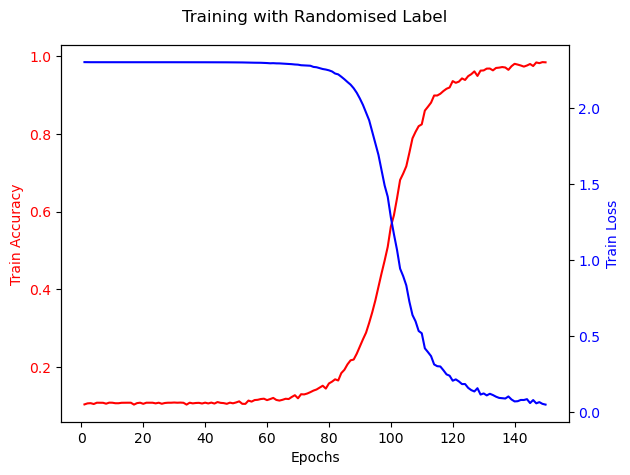

In [93]:
import matplotlib.pyplot as plt

# Sample data
epoch_range = range(1, epochs+1)  # 150 epochs
train_loss = [x[0] for x in training_performance_data]
train_accuracy = [x[1] for x in training_performance_data]

fig, ax1 = plt.subplots()

# Plotting training accuracy on the primary y-axis
color = 'r'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Accuracy', color=color)
ax1.plot(epoch_range, train_accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for the training loss
ax2 = ax1.twinx()
color = 'b'
ax2.set_ylabel('Train Loss', color=color)
ax2.plot(epoch_range, train_loss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding title and a tight layout
fig.suptitle('Training with Randomised Label')
fig.tight_layout()

# Show the plot
plt.show()